### 程序目标：获取特定刊物的文章标题，查看刊物的聚焦点（以`TVCG`在最近28年的文章为例）
1. 获取TVCG自1995年~2022年（共28年）的所有文章标题
2. 存放到MongoDB数据库中，基础字段为（year, title)
3. 依次将title进行分词
 * ① 直接切分，同时去除停用词与标点符号，并将分词结果放在对应记录的新字段下（新字段名：afterCutting）
 * `②` 考虑部分词经常一起出现，例如（'Data', 'Visualization')，所以直接切分会把一些组合词切开，无法获取隐藏的信息价值，所以，在①的基础上，`失败的尝试`一开始采用的方法是将某年的所有标题分割出来的词，进行排列组合，将组合结果加入过滤词表，但是最后发现了问题：每一篇文章标题的词也会进行排列组合，导致最后所有标题都会有组合词存在。`二次尝试`统计词频，将每年的词频大于1的词（也就是当年的文章标题中出现过至少2次及以上的次）进行组合，然后以此为组合词，进一步切分每个标题，获取的结果存入新字段下（新字段名：afterCutting_selfDefine）
4. 按年统计词频，绘图，观察
5. 获取全年词频，绘图，观察
6. 统计全28年的文章标题并输出，同时基于文章数绘制数量走势图

## 1
### 简单的数据爬取函数
* 爬取论文的标题（需要修改的地方，后面做了标记：`●`）

In [1]:
import requests
from bs4 import BeautifulSoup

def get_pages_within(startPage, endPage):
    SimpleInfo = list()
    for page_num in range(startPage, endPage + 1):
        wb_data = requests.get('https://dblp.uni-trier.de/db/journals/tvcg/tvcg{}.html'.format(page_num))  # ●
        soup = BeautifulSoup(wb_data.text, 'lxml')
        titles = soup.select('cite > span.title')
        year = 1994 + page_num
        for title in titles:
            data = {
                'year': year,
                'title': title.get_text()
            }
            SimpleInfo.append(data)

    return SimpleInfo

### 首先获取去除停用词和标点符号之后的词组
* 函数名为：`sentencesCutting_1`
* 入口参数：`sent` : 待切割的句子（这里是文章的title）

In [2]:
import nltk
from nltk.corpus import stopwords

def sentencesCutting_Init(sent):
    interpunctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%', '"']   # 定义符号列表
    stops = set(stopwords.words("english"))
    
    cutInit = nltk.word_tokenize(sent)  # 初始分词结果
    # print("cutInit: %s" % cutInit)

    # 去除标点符号和停用词
    cutPun8Sw = [word for word in cutInit if (word not in interpunctuations and word not in stops)]   # 去除标点符号

    return cutPun8Sw

In [3]:
# 获取28年每年的论文标题，Volume 1, 1995 -- Volume 28, 2022
SimpleInfo = get_pages_within(1, 28) 
print(f"从1995年到2022年，这28年总共有TVCG论文{len(SimpleInfo)}篇。")

从1995年到2022年，这28年总共有TVCG论文4480篇。


### 小函数集锦（保存、加载变量）

In [4]:
import pickle
# Input: 变量名，保存路径
# Output: 保存路径
def save_variable1(v, filename):
    f = open(filename, 'wb')
    pickle.dump(v, f, 0)  # 在dump()里加上第三个参数，设为0(ASCII协议).
    f.close()
    return filename

# Input: 保存的变量路径
# Output: 变量
def load_variable1(filename):
    f = open(filename, 'rb')
    r = pickle.load(f)
    f.close()
    return r

def save_variable2(v, filename):
    try: 
        # f = open('test001.txt','w',encoding='utf-8') #open 打开要写入的文件，'w'就是写入的意思，如果有中文encoding进行编码
        with open(filename,'w',encoding='utf-8') as f:
            f.write(v)  # write是写入的意思，将（）中的内容写入到f文件里
            
    # 无论try中的程序是否存在报错，则都执行下面的关闭
    finally: 
        if f:  # 判断下f是否打开了，如果没打开则不需要关闭，打开了则关闭
            f.close()
    return filename

def load_variable2(filename):
    # 首先try一下，如果程序打开以及在打开后读取一系列操作后有报错，则不中断程序
    try:  
        # f = open(filename, 'r', encoding='utf-8')
        with open(filename, 'r', encoding='utf-8') as f:
            strContent = f.read()
    # 无论try中的程序是否存在报错，则都执行下面的关闭
    finally:  
        if f:  # 判断下f是否打开了，如果没打开则不需要关闭，打开了则关闭
            f.close()
    return strContent

In [5]:
save_variable1(SimpleInfo, 'AllTitles_28years_withType.txt')

'AllTitles_28years_withType.txt'

In [7]:
save_variable2(str(SimpleInfo), 'AllTitles_28years_withoutType.txt')

'AllTitles_28years_withoutType.txt'

### 数据库、集合的删除相关操作

```python
# 删除指定数据库
exec("db.drop_database('" + targetDB + "')")  # db.drop_database('db_tvcg_28years')

# 删除目标集合内的指定字段
exec(targetCol + ".update_many({}, {'unset': {'testFields': ''}})")

# 删除目标集合内所有的文档
exec(targetCol + ".delete_many({})")
```

## 2
### 1/2 在新的数据库的新的集合内，插入爬取得到的`title`，同时新建一个`字段`，存放初始的分割结果

In [8]:
# 将爬取的数据，存到目标集合targetCol中
def saveData2Collection(SimpleInfo, targetCol, newField):
    # 操作对应的集合
    exec(targetCol + ".insert_many(SimpleInfo)")
    
    exec("exists = " + targetCol + ".find_one({'" + newField + "': {'$exists': True}})")
    loc = locals()
    if not loc['exists']:
        print("不存在，可新增！正在新建...")
        exec("recs = " + targetCol + ".find()")
        for c in loc['recs']: 
            exec(targetCol + ".update_one({'_id': c['_id']}, {'$set': {'" + newField + "': list()}})")
        print(targetCol + ": 新建完成！")
    else:
        print("已存在，无法新增！")    

### 2/2 分割文章的`title`放入新字段中

In [9]:
# 将目标集合targetCol中的字段分割，并且放到新字段里
def cutTitle2Fields(targetCol, newField):
    # 分词结束，这段代码就不执行了！
    exec("recs = " + targetCol + ".find()")
    loc = locals()
    for c in loc['recs']: 
        id = c['_id']
        title = c['title']
        cutTitle = sentencesCutting_Init(title) 
        if not c.get(newField):
            exec(targetCol + ".update_one({'_id': id}, {'$set': {'" + newField + "': cutTitle}})")

    print("Done!")

In [11]:
# 第二天重启jupyter notebook之后，前一天执行的所有变量都没了，所以需要重新连接一下数据库
import pymongo

db = pymongo.MongoClient("mongodb://localhost:27017/")

# 目标数据库
targetDB = 'db_tvcg_28years'
targetCol = 'col_tvcg_28years'

exec(targetDB + " = db['" + targetDB + "']")  # db_tvcg_28years = db["db_tvcg_28years"]
exec(targetCol + " = " + targetDB + "['" + targetCol + "']")  # col_tvcg_28years = db_tvcg_28years["col_tvcg_28years"] 

exec("tempCnt = " + targetCol + ".count_documents({})")
exec("print(f'当前数据库共有记录{tempCnt}条')")

当前数据库共有记录4480条


## 3-①

In [10]:
import pymongo
import sys

if __name__ == '__main__':
    
    db = pymongo.MongoClient("mongodb://localhost:27017/")

    # 目标数据库（没有则新建） ●
    targetDB = 'db_tvcg_28years'
    targetCol = 'col_tvcg_28years'
    
    # 避免重复，先删除掉已有的数据库
    exec("db.drop_database('" + targetDB + "')")  # db.drop_database('db_tvcg_28years')
    
    
    print(f"执行前所有数据库为：{db.list_database_names()}")
    exec(targetDB + " = db['" + targetDB + "']")  # db_tvcg_28years = db["db_tvcg_28years"]
    exec(targetCol + " = " + targetDB + "['" + targetCol + "']")  # col_tvcg_28years = db_tvcg_28years["col_tvcg_28years"] 

    
    print("--------------------------------------1/2")
    print("开始插入数据，并新建字段")
    
    newField = 'afterCutting'
    
    saveData2Collection(SimpleInfo, targetCol, newField)
    
    print("--------------------------------------2/2")
    print("开始对标题title进行分割")
    
    cutTitle2Fields(targetCol, newField)
    
    print(f"执行后所有数据库为：{db.list_database_names()}")

执行前所有数据库为：['admin', 'config', 'db_Weibo_SH0331', 'db_Weibo_SH_0331_All', 'db_tvcg3years', 'db_tvcg4years', 'db_tvcgR3', 'db_weiboDB', 'local', 'test', 'weiboInfoAll']
--------------------------------------1/2
开始插入数据，并新建字段
不存在，可新增！正在新建...
col_tvcg_28years: 新建完成！
--------------------------------------2/2
开始对标题title进行分割
Done!
执行后所有数据库为：['admin', 'config', 'db_Weibo_SH0331', 'db_Weibo_SH_0331_All', 'db_tvcg3years', 'db_tvcg4years', 'db_tvcgR3', 'db_tvcg_28years', 'db_weiboDB', 'local', 'test', 'weiboInfoAll']


#### 获取每年的`文章数`，和每年文章标题切分后得到的`所有分词`
`{1995: [titleNums, ['words1', 'words2', 'words3', ...]]}`

In [12]:
# 获取指定集合下指定字段
def getWordsbyYears(targetCol, newField, startYear, endYear):
    dictWords = {}
    
    loc = locals()
    for year in range(startYear, endYear + 1):
        tempWords = list()
        queryCondition = {"year": year}
        exec("recs = " + targetCol + ".find(queryCondition)")
        for cW in loc['recs']: 
            # 多个list合并为一个list
            tempWords = tempWords + cW.get(newField)  # 把指定年份的所有从标题分割出的词，放在一个list里

        exec("tempCnt = " + targetCol + ".count_documents(queryCondition)")  # 获取指定年份的所有标题数量
        dictWords[year] = [loc['tempCnt'], tempWords]
        
    return dictWords  # 返回一个字典，字典的key是年份，value是对应年份的文章数 & 分割词的总和

In [13]:
startYear = 1995
endYear = 2022
newField = 'afterCutting'

# dictWords拿到的是1995-2022年所有的数据
dictWords = getWordsbyYears(targetCol, newField, startYear, endYear)

# 打印1995年的数据出来看看(1995是key)
print(dictWords[1995])  # 输出的value是一个列表，列表第一个是数字，表示1995年发表了32篇文章，数字后面的列表是当年文章标题所有单词总和

[32, ['Editorials', 'Real', 'Time', 'Responsive', 'Animation', 'Personality', 'Visualizing', 'Network', 'Data', 'Volume', 'Rendering', 'DCT-Based', 'Compressed', '3D', 'Scalar', 'Data', 'Visualization', 'Multidimensional', 'Shape', 'Texture', 'Features', 'Laser', 'Range', 'Data', 'Using', 'Complex-Valued', 'Gabor', 'Wavelets', 'Optimal', 'Sampling', 'Hemicubes', 'Vision', '-', 'An', 'Architecture', 'Global', 'Illumination', 'Calculations', 'Visualization', 'Takes', 'Place', 'Scientific', 'Community', 'Optical', 'Models', 'Direct', 'Volume', 'Rendering', 'Multiscale', 'Volume', 'Representation', 'DoG', 'Wavelet', 'Grouping', 'Volume', 'Renderers', 'Enhanced', 'Visualization', 'Computational', 'Fluid', 'Dynamics', 'Using', 'Line', 'Integral', 'Convolution', 'Flow', 'Visualization', 'Curvilinear', 'Grids', 'Variable-Speed', 'Animation', 'Unsteady', 'Flows', 'Competent', 'Compact', 'Comparative', 'Visualization', 'Vortical', 'Flow', 'Field', 'A', 'Predictor-Corrector', 'Technique', 'Visual

#### 预览函数
* 查看指定年份的前`x%`, 例如`10%`的词

In [14]:
# 这个函数只用来查看，不用来修改任何值
def viewData(dictWords, year, per = 1.0):
    # 取某年的词频在前80%（默认）的词，查看→[词 - 词频]
    freqWords = dict()
    for eachWord in dictWords[year][1]:
        freqWords[eachWord] = freqWords.get(eachWord, 0) + 1

    items = list(freqWords.items())  # 转换为list
    print("items.len = " + str(len(items)))
    items.sort(key=lambda x: x[1], reverse=True)  # 按照词频排序
    
    topK = int(len(items) * per)  # 获取词频排在前100%的分词(如果per = 0.8，就是80%的分词)
    print("topK = %d" % topK)
    
    # 按照指定格式显示词 & 词频
    print("-----------------------------------")
    for i in range(topK):
        word, count = items[i]
        print("{0:<20}{1:>10}".format(word, count))
        
    
    reIndexDict = dict()
    for i in range(topK):
        word, count = items[i]
        # 重要代码 1：逆向索引，存储出现固定次数的词语。比如出现8次的词语有['a', 'b', 'c'], 就存为：{8: ['a', 'b', 'c']}
        reIndexDict.setdefault(count, list())
        reIndexDict[count].append(word)
    
    return reIndexDict

In [15]:
reIndexDict = viewData(dictWords, 1995, 0.5)  # 看一下1995年的最热的top 50%的标题词

items.len = 156
topK = 78
-----------------------------------
Visualization                8
Volume                       5
Rendering                    4
Using                        4
A                            4
Animation                    3
Data                         3
Flow                         3
Visualizing                  2
3D                           2
An                           2
Global                       2
Illumination                 2
Multiscale                   2
Line                         2
Unsteady                     2
System                       2
Editorials                   1
Real                         1
Time                         1
Responsive                   1
Personality                  1
Network                      1
DCT-Based                    1
Compressed                   1
Scalar                       1
Multidimensional             1
Shape                        1
Texture                      1
Features                     1
Laser   

In [16]:
print(reIndexDict[4])

# 输出倒序索引的结果，后续处理的就是词频>=2的所有词的组合
for key, value in reIndexDict.items():
    print(f"{key}: {value}")

['Rendering', 'Using', 'A']
8: ['Visualization']
5: ['Volume']
4: ['Rendering', 'Using', 'A']
3: ['Animation', 'Data', 'Flow']
2: ['Visualizing', '3D', 'An', 'Global', 'Illumination', 'Multiscale', 'Line', 'Unsteady', 'System']
1: ['Editorials', 'Real', 'Time', 'Responsive', 'Personality', 'Network', 'DCT-Based', 'Compressed', 'Scalar', 'Multidimensional', 'Shape', 'Texture', 'Features', 'Laser', 'Range', 'Complex-Valued', 'Gabor', 'Wavelets', 'Optimal', 'Sampling', 'Hemicubes', 'Vision', '-', 'Architecture', 'Calculations', 'Takes', 'Place', 'Scientific', 'Community', 'Optical', 'Models', 'Direct', 'Representation', 'DoG', 'Wavelet', 'Grouping', 'Renderers', 'Enhanced', 'Computational', 'Fluid', 'Dynamics', 'Integral', 'Convolution', 'Curvilinear', 'Grids', 'Variable-Speed', 'Flows', 'Competent', 'Compact', 'Comparative', 'Vortical', 'Field', 'Predictor-Corrector', 'Technique', 'Quaternion', 'Frame', 'Approach', 'Streamline', 'Obliq-3D', 'High-Level', 'Fast-Turnaround']


#### 人工检查部分，可以不理会

In [17]:
# 从数据库中把1995年的文章标题提取出来，看看统计的对不对（人工检验一下）
queryCondition = {"year": 1995}
res = col_tvcg_28years.find(queryCondition)
print(res)
findStr = 'Visualization'
cnt = 0
for r in res: 
    title = r.get('title')
    if findStr in title:
        cnt = cnt + 1
    print(title)

print("==================")
print(f"你没算错，{findStr}出现了{cnt}次")

Editorials.
Real Time Responsive Animation with Personality.
Visualizing Network Data.
Volume Rendering of DCT-Based Compressed 3D Scalar Data.
Visualization of Multidimensional Shape and Texture Features in Laser Range Data Using Complex-Valued Gabor Wavelets.
Optimal Sampling for Hemicubes.
Vision - An Architecture for Global Illumination Calculations.
Visualization Takes its Place in the Scientific Community.
Optical Models for Direct Volume Rendering.
Multiscale Volume Representation by a DoG Wavelet.
Grouping Volume Renderers for Enhanced Visualization in Computational Fluid Dynamics.
Using Line Integral Convolution for Flow Visualization: Curvilinear Grids, Variable-Speed Animation, and Unsteady Flows.
Competent, Compact, Comparative Visualization of a Vortical Flow Field.
A Predictor-Corrector Technique for Visualizing Unsteady Flow.
Quaternion Frame Approach to Streamline Visualization.
Obliq-3D: A High-Level, Fast-Turnaround 3D Animation System.
Visualization of Geometric Algo

## 3-②
### Code 1 ~ Code7
### 依次获取`每年`的`相同频率的关键词，进行排列组合`，形成词组，放到字典中，如下形式：
```python
{1995:  
    {
        8: ['Visualization'], 
        5: ['Volume'], 
        4: ['Rendering', 'Using', 'A'], 
        3: ['Animation', 'Data', 'Flow']
    }
}

↓↓↓↓↓↓↓↓↓↓

[('Rendering', 'Using'), ('Rendering', 'A'), ('Using', 'Rendering'), ('Using', 'A'), ('A', 'Rendering'), ('A', 'Using'), ('Animation', 'Data'), ('Animation', 'Flow'), ('Data', 'Animation'),...]
```

### Code 1

In [18]:
def getFreq_AllYears(dictWords, startYear, endYear, per = 1.0):
    
    Freq_AllYears = dict()
    for year in range(startYear, endYear + 1):
        freqWords = dict()
        for eachWord in dictWords[year][1]:
            freqWords[eachWord] = freqWords.get(eachWord, 0) + 1
            
        items = list(freqWords.items())  # 转换为list
        print(f"{year}: items.len = " + str(len(items)))
        items.sort(key=lambda x: x[1], reverse=True)  # 按照词频排序

        topK = int(len(items) * per)  # 获取词频排在前100%的分词(默认就是所有词)
        print("topK = %d" % topK)
        
        reIndexDict = dict()  # ▲

        for i in range(topK):
            word, count = items[i]        
            # 重要代码 1
            reIndexDict.setdefault(count, list())  # ▲
            reIndexDict[count].append(word)  # ▲

        Freq_AllYears[year] = reIndexDict
    
    return Freq_AllYears


### Code 2

In [19]:
Freq_AllYears = getFreq_AllYears(dictWords, 1995, 2022, per = 1.0)

1995: items.len = 156
topK = 156
1996: items.len = 158
topK = 158
1997: items.len = 149
topK = 149
1998: items.len = 134
topK = 134
1999: items.len = 131
topK = 131
2000: items.len = 132
topK = 132
2001: items.len = 163
topK = 163
2002: items.len = 145
topK = 145
2003: items.len = 217
topK = 217
2004: items.len = 281
topK = 281
2005: items.len = 346
topK = 346
2006: items.len = 660
topK = 660
2007: items.len = 714
topK = 714
2008: items.len = 688
topK = 688
2009: items.len = 682
topK = 682
2010: items.len = 661
topK = 661
2011: items.len = 922
topK = 922
2012: items.len = 999
topK = 999
2013: items.len = 1034
topK = 1034
2014: items.len = 1054
topK = 1054
2015: items.len = 614
topK = 614
2016: items.len = 1027
topK = 1027
2017: items.len = 1072
topK = 1072
2018: items.len = 1182
topK = 1182
2019: items.len = 1239
topK = 1239
2020: items.len = 1267
topK = 1267
2021: items.len = 1532
topK = 1532
2022: items.len = 1244
topK = 1244


### Code 3

In [20]:
# print(Freq_AllYears[1995])
for key, value in Freq_AllYears[1995].items():
    print(f"{key}: {value}")

8: ['Visualization']
5: ['Volume']
4: ['Rendering', 'Using', 'A']
3: ['Animation', 'Data', 'Flow']
2: ['Visualizing', '3D', 'An', 'Global', 'Illumination', 'Multiscale', 'Line', 'Unsteady', 'System']
1: ['Editorials', 'Real', 'Time', 'Responsive', 'Personality', 'Network', 'DCT-Based', 'Compressed', 'Scalar', 'Multidimensional', 'Shape', 'Texture', 'Features', 'Laser', 'Range', 'Complex-Valued', 'Gabor', 'Wavelets', 'Optimal', 'Sampling', 'Hemicubes', 'Vision', '-', 'Architecture', 'Calculations', 'Takes', 'Place', 'Scientific', 'Community', 'Optical', 'Models', 'Direct', 'Representation', 'DoG', 'Wavelet', 'Grouping', 'Renderers', 'Enhanced', 'Computational', 'Fluid', 'Dynamics', 'Integral', 'Convolution', 'Curvilinear', 'Grids', 'Variable-Speed', 'Flows', 'Competent', 'Compact', 'Comparative', 'Vortical', 'Field', 'Predictor-Corrector', 'Technique', 'Quaternion', 'Frame', 'Approach', 'Streamline', 'Obliq-3D', 'High-Level', 'Fast-Turnaround', 'Geometric', 'Algorithms', 'In', 'Memoriam

### Code 4

In [21]:
from itertools import permutations

print(Freq_AllYears[1995].keys())  # dict_keys([8, 5, 4, 3, 2, 1])

'''
词频依次为：8, 5, 4, 3, 2, 1
对应的词数为：1, 1, 3, 3, 9, xxxx
得到的组合词数量是：0, 0, 3*2, 3*2, 9*8 (累加起来：84)
8: ['Visualization']
5: ['Volume']
4: ['Rendering', 'Using', 'A']
3: ['Animation', 'Data', 'Flow']
2: ['Visualizing', '3D', 'An', 'Global', 'Illumination', 'Multiscale', 'Line', 'Unsteady', 'System']
1: ['Editorials', 'Real', 'Time', 'Responsive', 'Personality', 'Network',...]
'''
def generateInitPhrases_v2(Freq_AllYears, startYear, endYear):
    
    permut_AllYears = dict()
    
    for year in range(startYear, endYear + 1):
        tempMwe = list()
        for k, v in Freq_AllYears[year].items():
            if k > 1:
#                 print(len(v))
                for p in permutations(v, 2):
                    tempMwe.append(p)
        
        permut_AllYears[year] = tempMwe

    return permut_AllYears

dict_keys([8, 5, 4, 3, 2, 1])


### Code 5

In [22]:
# 小单元测试
testRes = generateInitPhrases_v2(Freq_AllYears, 1995, 1995)
print(testRes[1995])
print(len(testRes[1995]))

[('Rendering', 'Using'), ('Rendering', 'A'), ('Using', 'Rendering'), ('Using', 'A'), ('A', 'Rendering'), ('A', 'Using'), ('Animation', 'Data'), ('Animation', 'Flow'), ('Data', 'Animation'), ('Data', 'Flow'), ('Flow', 'Animation'), ('Flow', 'Data'), ('Visualizing', '3D'), ('Visualizing', 'An'), ('Visualizing', 'Global'), ('Visualizing', 'Illumination'), ('Visualizing', 'Multiscale'), ('Visualizing', 'Line'), ('Visualizing', 'Unsteady'), ('Visualizing', 'System'), ('3D', 'Visualizing'), ('3D', 'An'), ('3D', 'Global'), ('3D', 'Illumination'), ('3D', 'Multiscale'), ('3D', 'Line'), ('3D', 'Unsteady'), ('3D', 'System'), ('An', 'Visualizing'), ('An', '3D'), ('An', 'Global'), ('An', 'Illumination'), ('An', 'Multiscale'), ('An', 'Line'), ('An', 'Unsteady'), ('An', 'System'), ('Global', 'Visualizing'), ('Global', '3D'), ('Global', 'An'), ('Global', 'Illumination'), ('Global', 'Multiscale'), ('Global', 'Line'), ('Global', 'Unsteady'), ('Global', 'System'), ('Illumination', 'Visualizing'), ('Illum

In [23]:
# deprecated 弃用
import sys
from itertools import permutations

def generateInitPhrases(Freq_AllYears, startYear, endYear):
    
    sys.exit()
    permut_AllYears = dict()
    
    for year in range(startYear, endYear + 1):
        tempMwe = list()
        for p in permutations(Freq_AllYears[year].keys(), 2):
            tempMwe.append(p)
            
        permut_AllYears[year] = tempMwe

    return permut_AllYears

### Code 6

In [24]:
permut_AllYears = generateInitPhrases_v2(Freq_AllYears, 1995, 2022)

### Code 7

In [25]:
print(permut_AllYears[1995][0:3])
print(permut_AllYears[1996][0:3])
print("...")
print(permut_AllYears[2022][0:3])

[('Rendering', 'Using'), ('Rendering', 'A'), ('Using', 'Rendering')]
[('Volume', 'Rendering'), ('Rendering', 'Volume'), ('Editorial', 'Algorithm')]
...
[('3D', 'Analysis'), ('Analysis', '3D'), ('Interactive', 'With')]


### Code 8 ~ Code 11
### 下面的代码，看看组合词的情况，并且把组合词合并起来
 *Have a look*. 看一下每年的组合词的数量以及28年总共产生的组合词的数量（不一定每个组合词都是存在的）

### Code 8

In [26]:
print("每年词频大于1的词，组成的词组，数量依次为：")
print("==========================")
cnt = 0
for i in range(1995, 2022):
    print(f"{i}年：{len(permut_AllYears[i])}")
    cnt = cnt + len(permut_AllYears[i])
    
print(f"\n组合词的总数为: {cnt}")

每年词频大于1的词，组成的词组，数量依次为：
1995年：84
1996年：464
1997年：240
1998年：312
1999年：474
2000年：396
2001年：176
2002年：284
2003年：376
2004年：1680
2005年：1850
2006年：11554
2007年：11730
2008年：8918
2009年：7650
2010年：7568
2011年：18014
2012年：26530
2013年：27068
2014年：22968
2015年：7312
2016年：20286
2017年：24716
2018年：32656
2019年：28030
2020年：36170
2021年：41502

组合词的总数为: 339008


### Code 9

In [27]:
def combineTuple(permut_AllYears, startYear, endYear):
    MWE_all = list()
    for year in range(startYear, endYear):
        MWE_all = MWE_all + permut_AllYears[year]  # 多个list合并为一个list
        
    return MWE_all

### Code 10

In [28]:
MWE_all = combineTuple(permut_AllYears, startYear, endYear)
print(len(MWE_all))

339008


### Code 11

In [29]:
# MWE_all即为1995年-2022年标题词总和（每年的标题词各自组合）
print(MWE_all[0:10])

[('Rendering', 'Using'), ('Rendering', 'A'), ('Using', 'Rendering'), ('Using', 'A'), ('A', 'Rendering'), ('A', 'Using'), ('Animation', 'Data'), ('Animation', 'Flow'), ('Data', 'Animation'), ('Data', 'Flow')]


### 下面把`MWE_all`这个带入到分词的过程中，把语义相关的词留下来（有点暴力，但是小规模还是比较有效的）
* 例如，对于title: `Real Time Responsive Animation with Personality.`
* 初试分割会变成：`['Real', 'Time', 'Responsive', 'Animation', 'Personality']`
* 加入了自定义词组`[（'Real', 'Time')]`之后，再次分割的结果则为：`['Real Time', 'Responsive', 'Animation', 'Personality']`

#### 小范围测试

In [30]:
str1 = 'FlowSense: A Natural Language Interface for Visual Data Exploration within a Dataflow-System.'
str2 = 'Data-Changes Everything: Challenges and Opportunities in Data Visualization Design Handoff.'

In [31]:
import nltk
from nltk.corpus import stopwords

# 增加组合词
mwe_tokenizer = nltk.tokenize.MWETokenizer(MWE_all)

#### 小工具-去除标点符号

In [32]:
# 去除字符串中的标点符号
import re

interpunctuations = ',.:;?()[]&!*@#$%"'   # 定义符号列表
out = str2.translate(str.maketrans('', '', interpunctuations))
print(out)

Data-Changes Everything Challenges and Opportunities in Data Visualization Design Handoff


#### 对比前后，发现去除标点符号后，更精准了（最后一个单词的实心点没了）

##### 对比1/2：没有去除标点符号，直接分词

In [34]:
result2 = mwe_tokenizer.tokenize(str2.split())
print(result2)

['Data-Changes', 'Everything:', 'Challenges', 'and', 'Opportunities', 'in', 'Data_Visualization', 'Design', 'Handoff.']


##### 对比2/2：先去除标点符号，然后再分词

In [35]:
result2 = mwe_tokenizer.tokenize(out.split())
print(result2)

['Data-Changes', 'Everything', 'Challenges', 'and', 'Opportunities', 'in', 'Data_Visualization', 'Design', 'Handoff']


In [36]:
# result2里存在这个：'Handoff.'，带有实心点，所以在分词前，要去除每个单词的附加符号。

interpunctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%', '"']   # 定义符号列表
a = ''
for i in interpunctuations:
    a = a + i
    
a

',.:;?()[]&!*@#$%"'

### 二次处理标题

In [37]:
# 增加组合词 → 分词 → 去除标点符号和停用词
import nltk
from nltk.corpus import stopwords
import re

def sentencesCutting_plus(sent, mwe_tokenizer):
    interpunctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%']   # 定义符号列表
    stops = set(stopwords.words("english"))
       
    # 去除除了'-'之外的标点符号，避免出现分词结果里有这样的情况(标题最后一个单词带实心点）：  'Personality.'
    interpunctuations = ',.:;?()[]&!*@#$%"'   # 定义符号列表
    sent = sent.translate(str.maketrans('', '', interpunctuations))

    cutInit_plus = mwe_tokenizer.tokenize(sent.split())

    # 去除标点符号和停用词
    cutPun8Sw = [word for word in cutInit_plus if (word not in interpunctuations and word not in stops)]   # 去除标点符号

    return cutPun8Sw

In [38]:
# 新建字段
def makeNewField(targetCol, newField):
    
    exec("exists = " + targetCol + ".find_one({'" + newField + "': {'$exists': True}})")
    loc = locals()
    if not loc['exists']:
        print("不存在，可新增！正在新建...")
        exec("recs = " + targetCol + ".find()")
        for c in loc['recs']: 
            exec(targetCol + ".update_one({'_id': c['_id']}, {'$set': {'" + newField + "': list()}})")
        print(targetCol + ": 新建完成！")
    else:
        print("已存在，无法新增！")    

In [39]:
# 将目标集合targetCol中的字段分割，并且放到新字段里
def cutTitle2Fields_plus(targetCol, newField, mwe_tokenizer):
    # 分词结束，这段代码就不执行了！
    exec("recs = " + targetCol + ".find()")
    loc = locals()
    for c in loc['recs']: 
        id = c['_id']
        title = c['title']
        cutTitle = sentencesCutting_plus(title, mwe_tokenizer) 
        if not c.get(newField):
            exec(targetCol + ".update_one({'_id': id}, {'$set': {'" + newField + "': cutTitle}})")

    print("Done!")

``` python
# 删除目标集合内的指定字段
exec(targetCol + ".update_many({}, {'unset': {'xxx': ''}})")
```

In [40]:
import pymongo
import sys

if __name__ == '__main__':
    
    db = pymongo.MongoClient("mongodb://localhost:27017/")

    # 目标数据库（没有则新建） ●
    targetDB = 'db_tvcg_28years'
    targetCol = 'col_tvcg_28years'
    
    
    
    print("--------------------------------------")
    print("新建字段，开始二次处理原title")
    
    newField = 'afterCutting_selfDefine'
    
    makeNewField(targetCol, newField)
    
    print("--------------------------------------")
    print("开始对标题title进行分割")
    
    # 增加组合词
    mwe_tokenizer = nltk.tokenize.MWETokenizer(MWE_all)  # 这个要传入参数mwe_tokenizer
    cutTitle2Fields_plus(targetCol, newField, mwe_tokenizer)
    

--------------------------------------
新建字段，开始二次处理原title
不存在，可新增！正在新建...
col_tvcg_28years: 新建完成！
--------------------------------------
开始对标题title进行分割
Done!


## `1 2 3` 结束，下面统计在增加了组合词之后的词频情况，即，开始执行`4 5`

## 4 按年统计词频，绘图，观察

In [41]:
# key：年份
# value: 年份中所有词的数量，不一样的词的数量，词频字典

def computeWordFreq(targetCol, year, wordFreqDict, per = 1.0):
    
    wordFreqDict[year] = list()
    queryCondition = {"year": year}
    
    exec(targetCol + " = db_tvcg_28years['" + targetCol+ "']")
    loc = locals()
    
    tempCnt_Words = 0  # ●1 存放当前集合中的词的总数

    freqWords = {}  # key(词汇)，value(词频数)

    
    exec("recs = " + targetCol + ".find(queryCondition)")
    for cW in loc['recs']:
        # 手动写词频统计函数，基于字典实现
        currentContent = cW.get('afterCutting_selfDefine')
        tempCnt_Words = tempCnt_Words + len(currentContent)  # 存放当前集合中的词的总数

        for eachWord in currentContent:
            freqWords[eachWord] = freqWords.get(eachWord, 0) + 1

    items = list(freqWords.items())  # 转换为list
    length = len(items)
    
    # print("items.len = " + str(len(items)))  # ●2 不一样的词的个数
    items.sort(key=lambda x: x[1], reverse=True)  # 按照词频排序
    
    
    wordcloudDic = dict()  # ●3 存放前k个词 & 词频
    
    top_k = int(length * per)
    
    for i in range(top_k):
        word, count = items[i]
        wordcloudDic[word] = count
        
    wordFreqDict[year].append(tempCnt_Words)  # 当年的文章拆分的总词数，比如['a', 'a', 'b', 'c']  总共4个词
    wordFreqDict[year].append(len(items))  # 不一样的词数，比如['a', 'a', 'b', 'c']  不一样的有3个词
    wordFreqDict[year].append(wordcloudDic) # 不一样的词 & 词频
    
    # 函数没有返回值，用形参返回，相当于C中的指针

#### 小范围看看1995年的统计情况

In [42]:
targetCol = 'col_tvcg_28years'
wordFreqDict = dict()  # 这个传入的时候是空字典，传出的时候已经保存了所有处理得到的结果

computeWordFreq(targetCol, 1995, wordFreqDict, 1.0)  # 小范围试试1995年的情况

for k, v in wordFreqDict.items():
    print(f"key = {k}, value = {v}")

key = 1995, value = [161, 143, {'Visualization': 8, 'A': 4, 'Using': 3, 'Animation': 2, 'Data': 2, 'Volume_Rendering': 2, 'Global_Illumination': 2, 'Flow': 2, 'System': 2, 'Editorials': 1, 'Real_Time': 1, 'Responsive': 1, 'Personality': 1, 'Visualizing_Network': 1, 'DCT-Based': 1, 'Compressed': 1, '3D': 1, 'Scalar': 1, 'Multidimensional_Shape': 1, 'Texture_Features': 1, 'Laser': 1, 'Range': 1, 'Data_Using': 1, 'Complex-Valued': 1, 'Gabor': 1, 'Wavelets': 1, 'Optimal': 1, 'Sampling': 1, 'Hemicubes': 1, 'Vision': 1, '-_An': 1, 'Architecture': 1, 'Calculations': 1, 'Takes': 1, 'Place': 1, 'Scientific': 1, 'Community': 1, 'Optical_Models': 1, 'Direct_Volume': 1, 'Rendering': 1, 'Multiscale': 1, 'Volume_Representation': 1, 'DoG': 1, 'Wavelet': 1, 'Grouping': 1, 'Volume': 1, 'Renderers': 1, 'Enhanced': 1, 'Computational': 1, 'Fluid_Dynamics': 1, 'Line_Integral': 1, 'Convolution': 1, 'Curvilinear': 1, 'Grids': 1, 'Variable-Speed': 1, 'Unsteady': 1, 'Flows': 1, 'Competent': 1, 'Compact': 1, 'C

### 大范围操作，并把结果变量保存下来

In [43]:
targetCol = 'col_tvcg_28years'
wordFreqDict = dict()

for year in range(1995, 2023):
    computeWordFreq(targetCol, year, wordFreqDict, 1.0)

In [44]:
save_variable1(wordFreqDict, 'wordFreqDict.txt')

'wordFreqDict.txt'

---

### 按年存储`词-词频`，并绘制词频图看看

In [45]:
# 分年存储
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import ImageFont

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


def pltFig(year, num):
    all_WordDict = wordFreqDict.get(year)[2]  # 下标为2的存的是词频字典

    cur_WordDict = dict()
    for k, v in all_WordDict.items():
        if v > num:
            cur_WordDict[k] = v
    print(year)
    print("====================")
    for kk,vv in cur_WordDict.items():
        print("{0:<20}{1:>10}".format(kk, vv))
    print("========================================")

    # ------------------------------------------ 词频图
    x1 = list(cur_WordDict.keys())
    y1 = list(cur_WordDict.values())
    plt.figure(figsize=(16, 6))
    plt.plot(x1, y1)
    plt.xticks(rotation=60)  # 设置x轴上的刻度旋转角度
    plt.ylabel('次数')
    plt.title(str(year) + '词频图')


1995
Visualization                8
A                            4
Using                        3
Animation                    2
Data                         2
Volume_Rendering             2
Global_Illumination          2
Flow                         2
System                       2
1996
A                            9
Using                        6
Editorial                    3
Visualization                3
Analysis                     3
Solids                       2
Near_Optimal                 2
Isosurface                   2
Extraction_Algorithm         2
Span_Space                   2
Framework                    2
Efficient                    2
Interactive                  2
Data                         2
Volume                       2
Image                        2
1997
The                          3
3D                           3
Using                        3
A                            3
Visualization                3
Expansion                    2
Polygonal               

2008
Visualization               35
Data                        19
A                           18
Using                       11
Visual                       9
Exploration                  9
Interactive                  8
Information                  7
Rendering                    7
Flow                         7
Surfaces                     7
Analysis                     7
3D                           5
Method                       5
Arbitrary                    5
The                          5
Interactive_Visual           5
Methods                      4
Approach                     4
Adaptive                     4
Dynamic                      4
Reconstruction               4
Design                       4
Application                  4
Networks                     4
Graph                        4
using                        4
Virtual                      3
Evaluation                   3
Surface_Extraction           3
Image                        3
Body                         3
Fas

2012
Visualization               50
Using                       25
A                           25
Visual                      25
Data                        17
Analysis                    15
Interactive                 13
Design                      11
3D                          10
Rendering                   10
Model                        9
An                           9
Visualizing                  8
Information                  8
Editor's                     7
Guest                        7
Introduction_Special         7
Section                      7
Approach                     7
Virtual_Environments         7
Video                        6
Efficient                    6
Exploration                  6
Analytics                    6
Evaluation                   6
Symposium                    5
Based                        5
The                          5
Animation                    5
Virtual_Reality              5
Visualizations               5
Dynamic                      4
Sys

Simulation                   4
Algorithm                    4
Networks                     4
Activity                     4
Datasets                     4
Perception                   4
Tracking                     4
Mapping                      4
Framework                    4
Large                        4
Sparse                       4
-                            4
Image                        3
Object                       3
Guest                        3
Introduction_Special         3
Section                      3
Symposium                    3
Moving                       3
Fields                       3
Local                        3
Volume_Rendering             3
Error                        3
Control                      3
Meshing                      3
Rendering                    3
Reconstruction               3
Adaptive                     3
Distance                     3
An_Evaluation                3
Cues                         3
Implicit                     3
Message 

C:\Users\t\AppData\Local\Temp\ipykernel_22716\3555416124.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16, 6))


2016
Visual                      37
Visualization               37
A                           30
Data                        25
Analysis                    20
Analytics                   11
Using                       11
Exploration                 10
3D                          10
Tracking                     9
Interactive                  9
Approach                     8
An                           8
via                          8
The                          8
Effects                      7
Image                        6
Study                        5
Temporal                     5
Evaluation                   5
Visualizing                  5
Effective                    5
Editor's                     5
Latency                      5
Virtual                      5
Augmented_Reality            5
Network                      4
Interaction                  4
Text                         4
Models                       4
Visualizations               4
Simulation                   4
Eff

Visualization               34
A                           34
Data                        26
Analysis                    22
The                         17
Using                       17
Exploration                 15
Interactive                 13
Virtual                     12
Analytics                   10
Augmented_Reality           10
Virtual_Reality             10
Visualizing                  9
Approach                     9
Rendering                    8
3D                           8
Models                       7
Dynamic                      7
An                           7
Tasks                        7
Networks                     6
Graph                        6
Learning                     6
Tool                         6
Visualizations               6
Message                      5
Do                           5
Study                        5
Exploring                    5
Based                        5
via                          5
Image                        5
IEEE    

Data_Analysis                4
Effect                       4
Point_Clouds                 4
During                       4
Virtual_Environments         4
Quality                      4
Based                        4
Deep_Learning                4
Large                        4
Network                      4
Reconstruction               4
Motion                       4
Semantic                     4
Cloud                        4
Display                      4
Framework                    4
Reality                      4
Objects                      4
Single                       4
Spatial                      4
Effects                      4
Scenes                       4
Boundaries                   4
Visual_Data                  3
System                       3
Understanding                3
Design_Study                 3
Scalar                       3
Temporal                     3
Combining                    3
Hierarchical                 3
Sequence                     3
Tracking

2022
A                           44
Visual                      34
Visualization               27
Data                        23
3D                          18
Analysis                    18
Using                       17
Virtual_Reality             14
Approach                    11
Interactive                 11
With                        11
Augmented_Reality           11
Learning                    10
An                           9
Analytics                    9
Exploration                  8
VR                           8
Design                       7
Immersive                    7
The                          7
Exploring                    6
Charts                       6
Framework                    6
IEEE                         6
Rendering                    6
Networks                     6
Real-Time                    6
Graph                        5
Towards                      5
Models                       5
Understanding                5
Study                        5
Dee

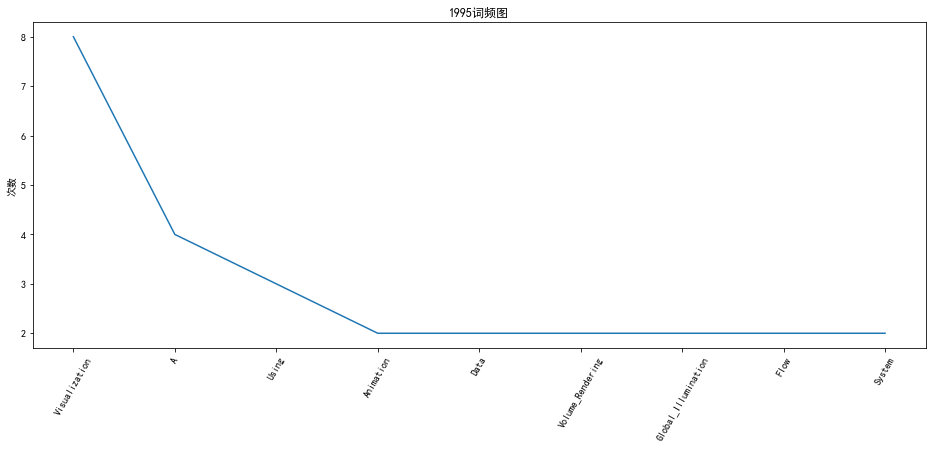

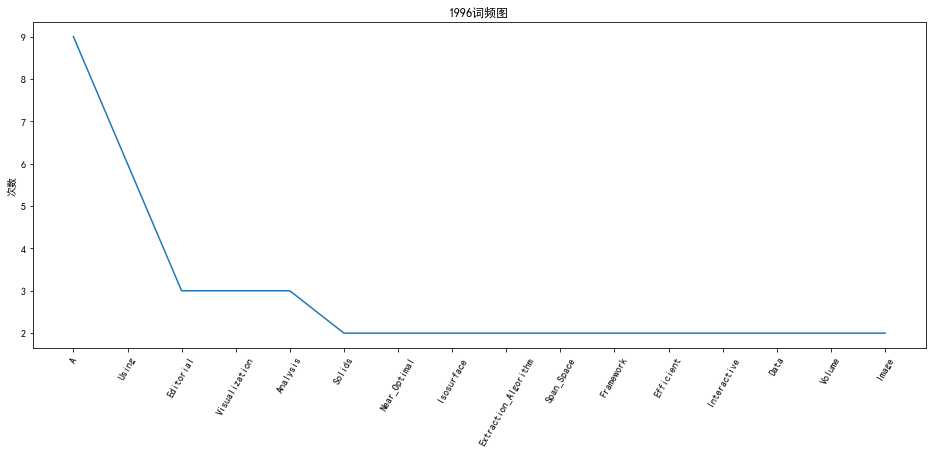

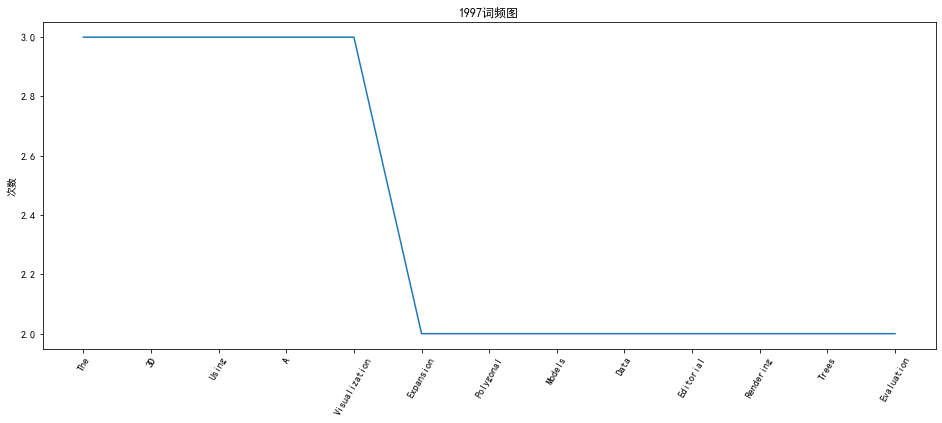

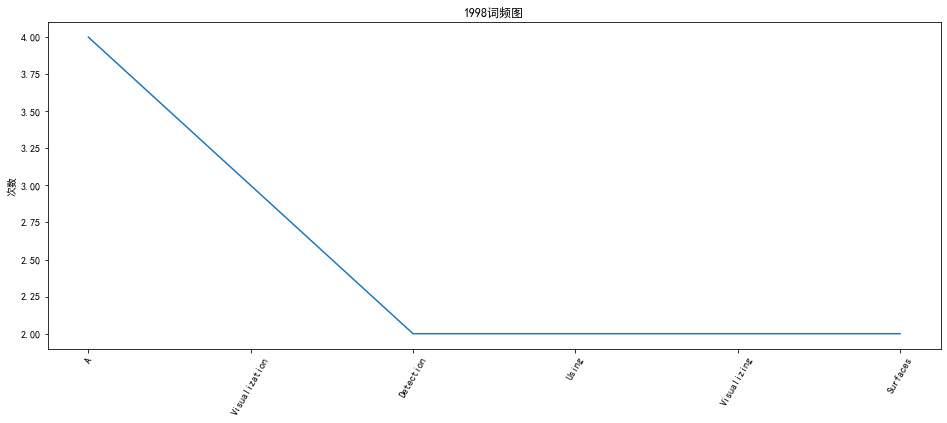

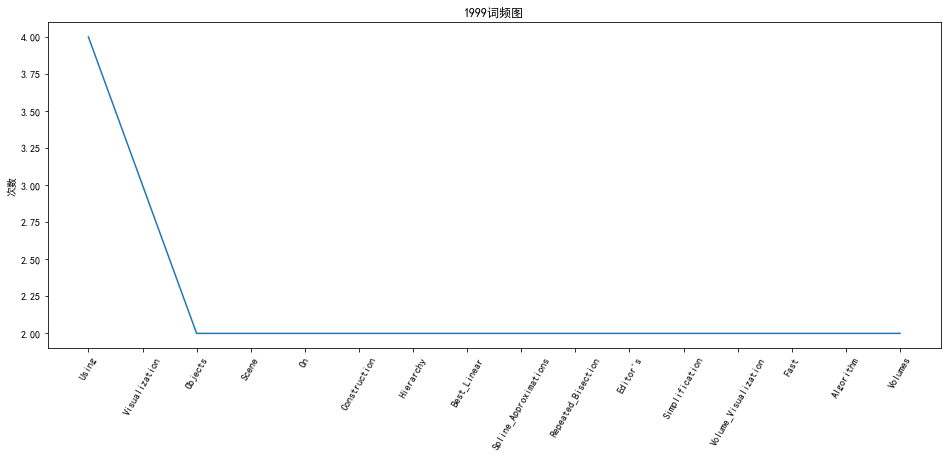

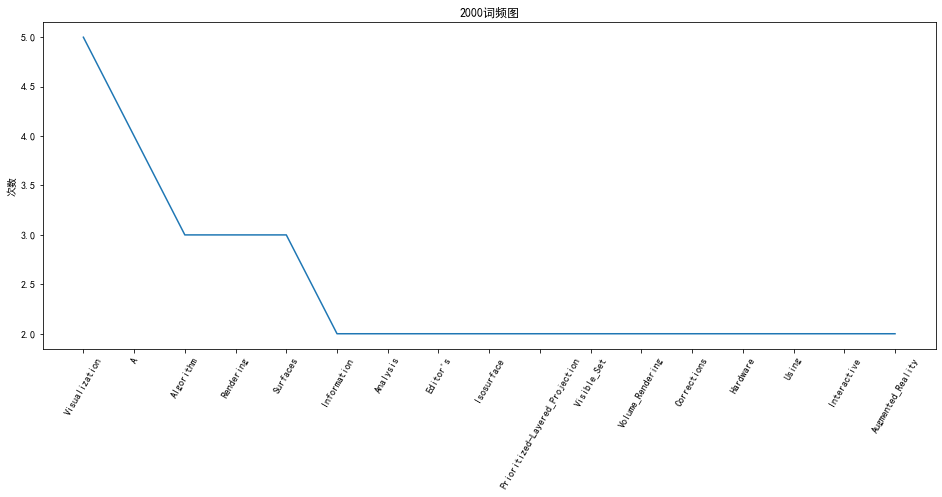

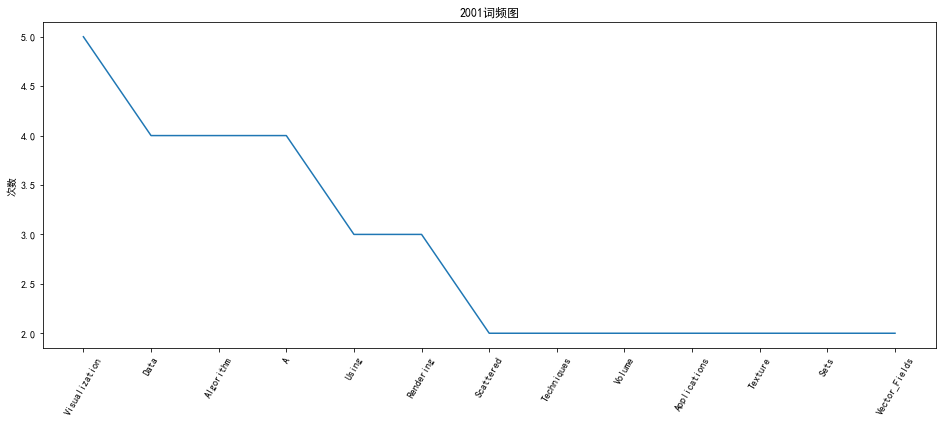

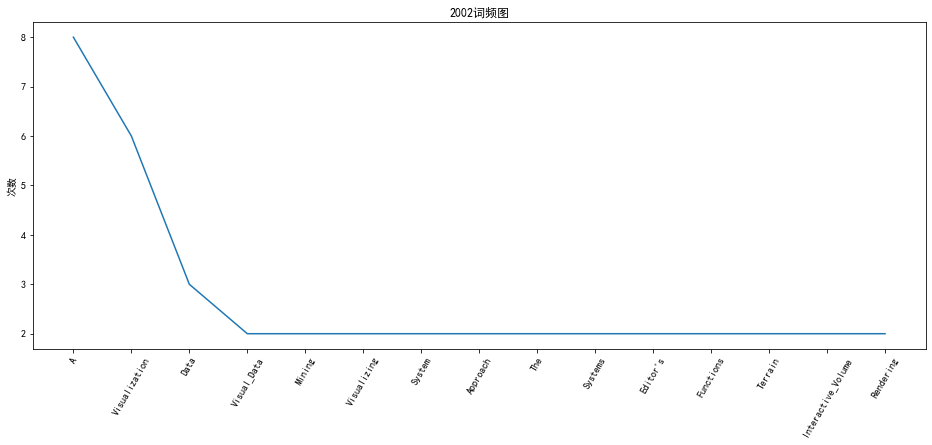

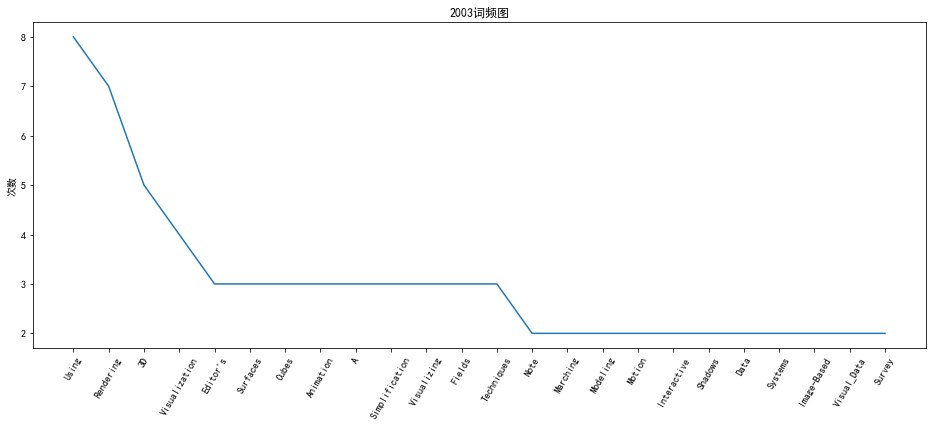

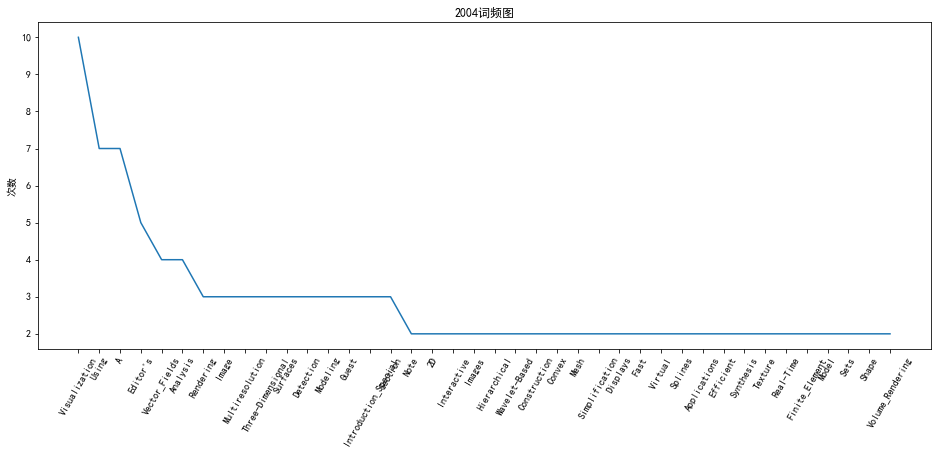

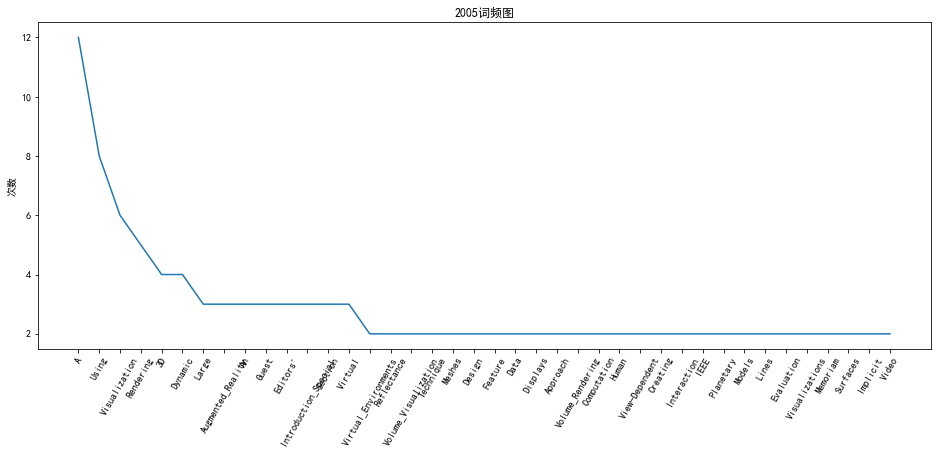

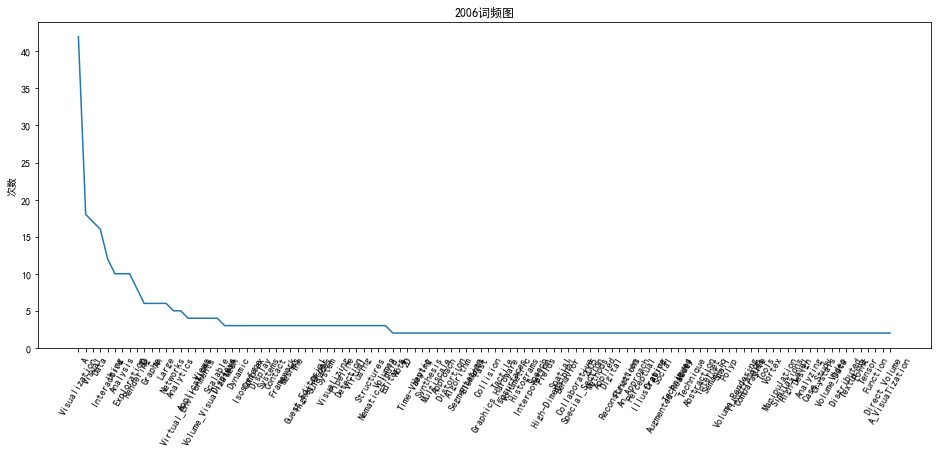

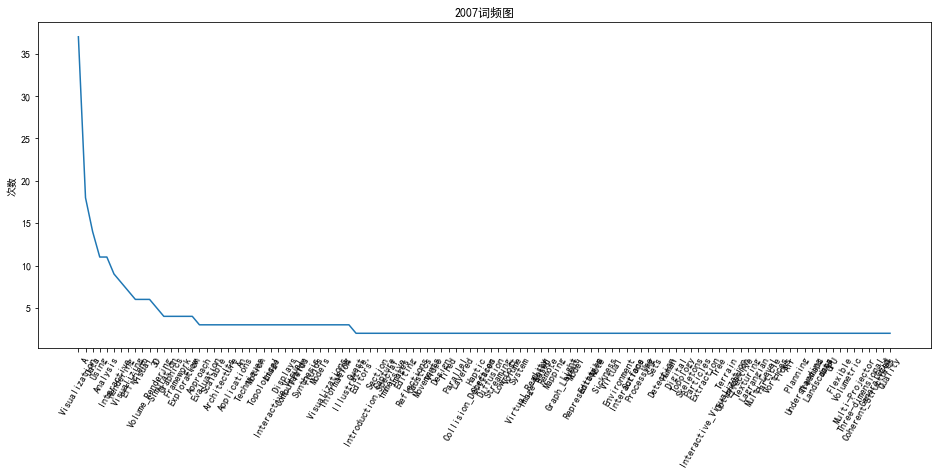

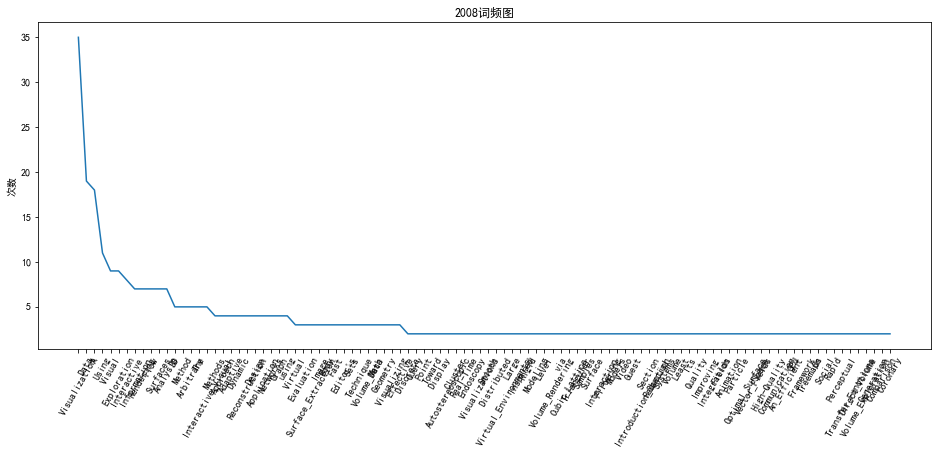

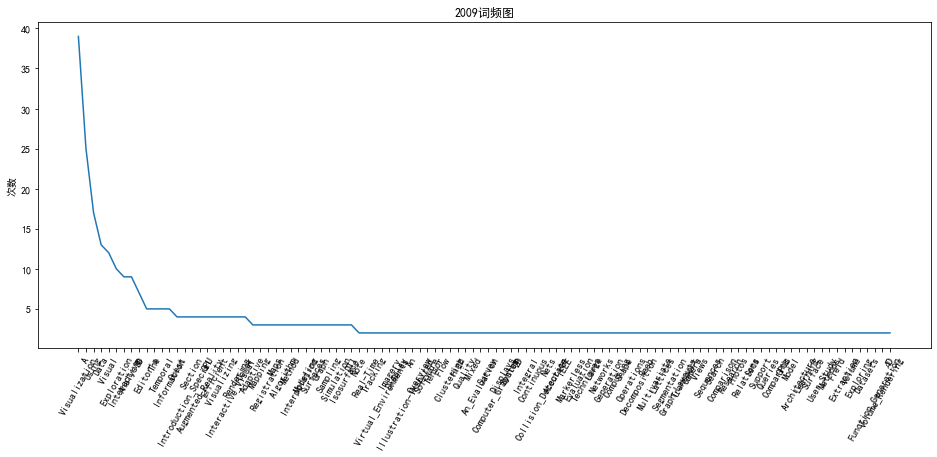

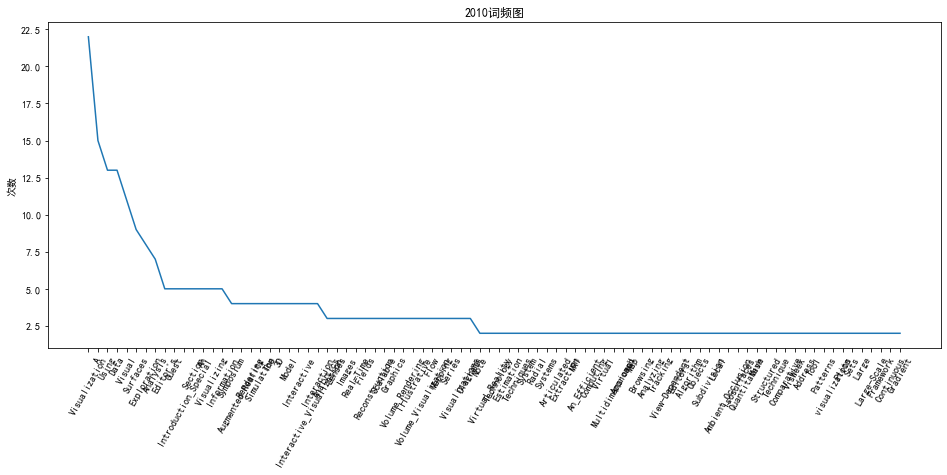

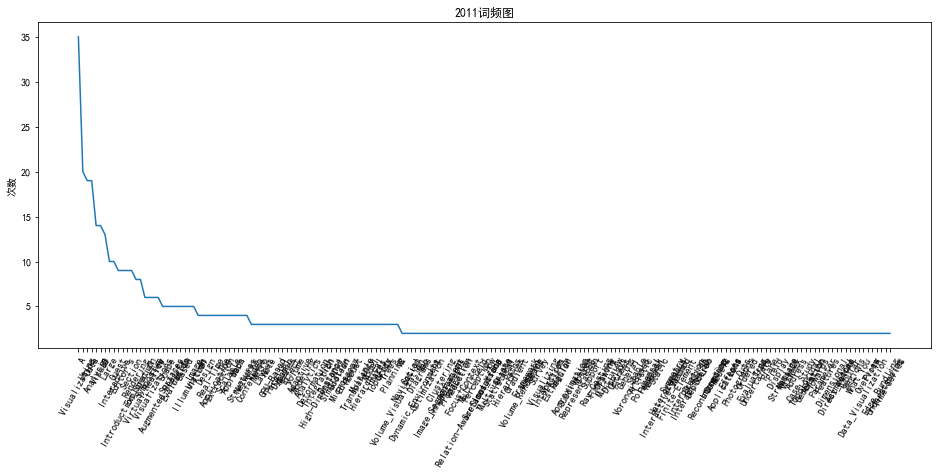

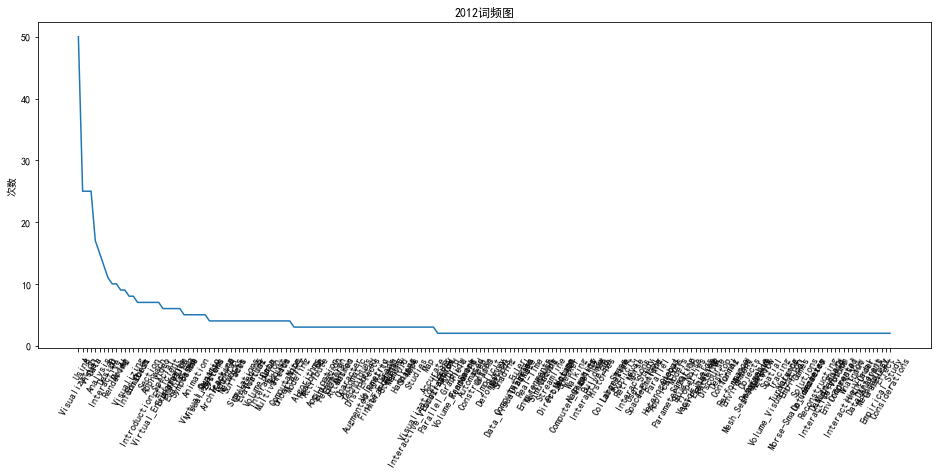

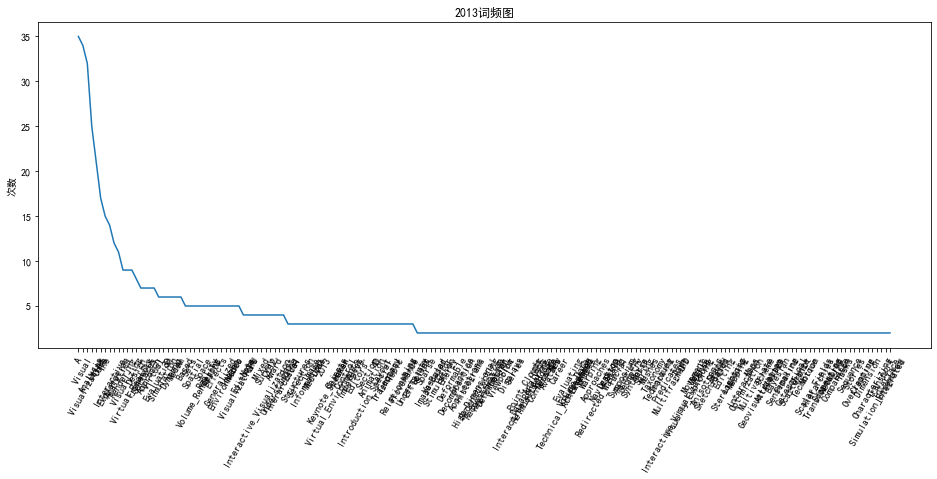

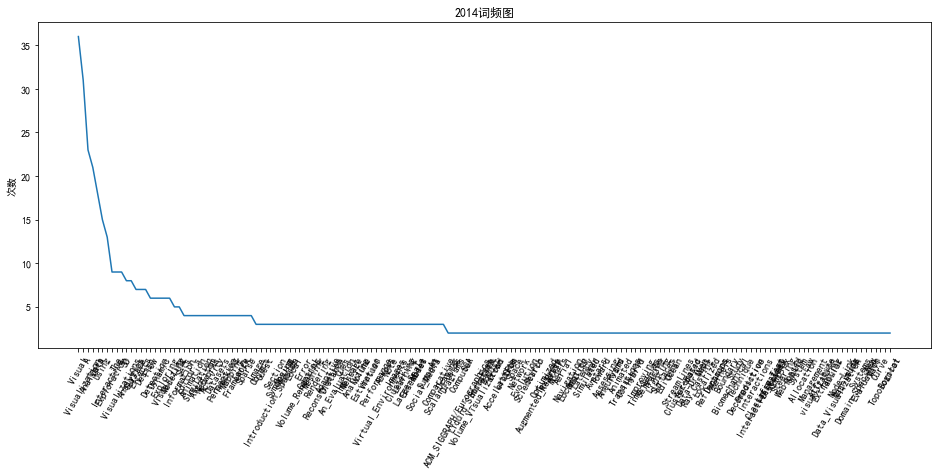

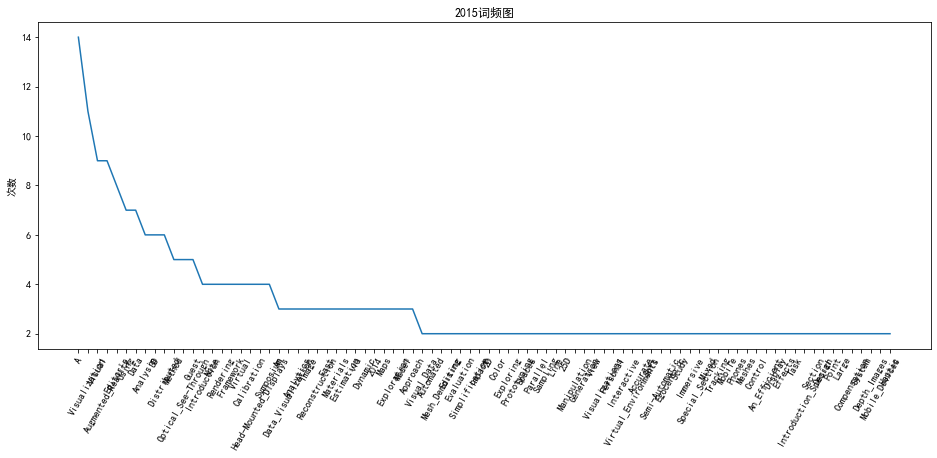

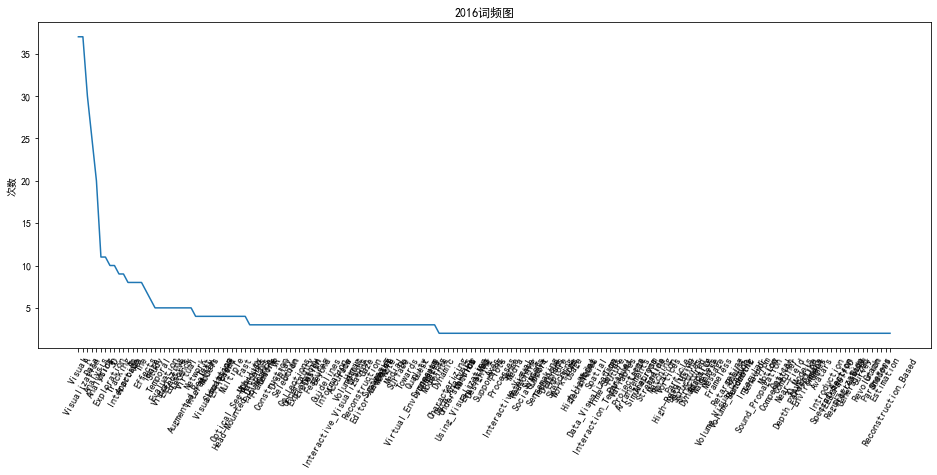

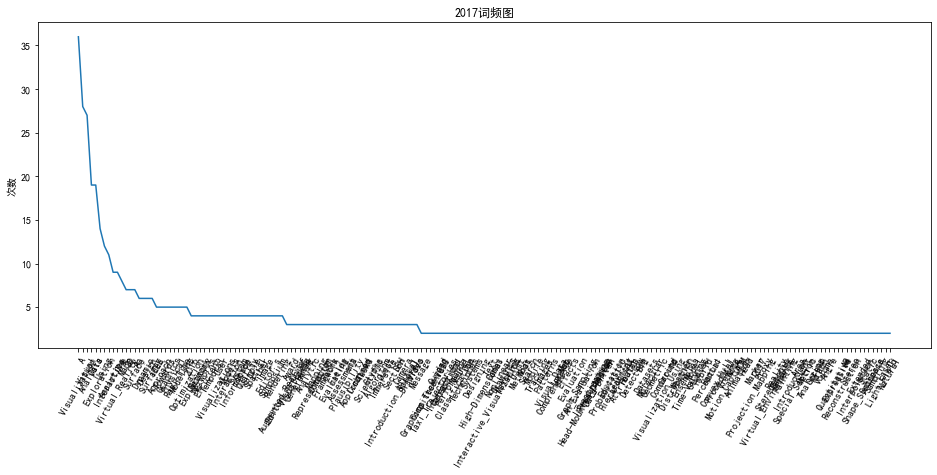

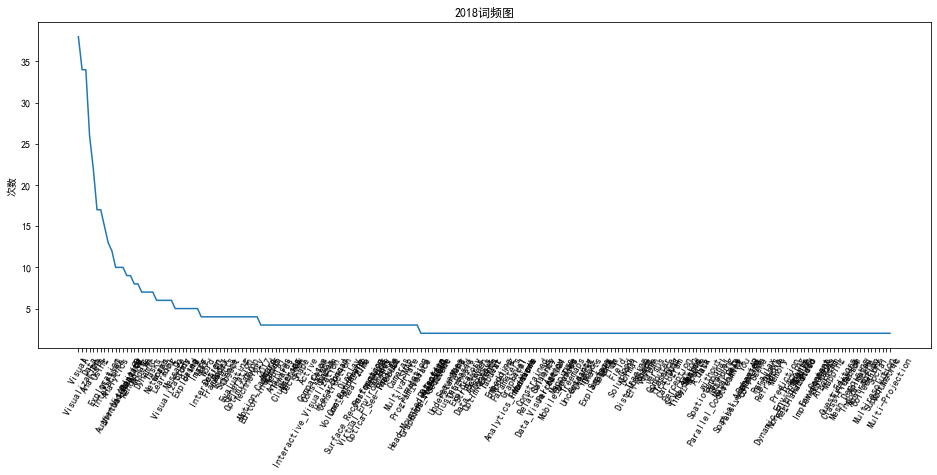

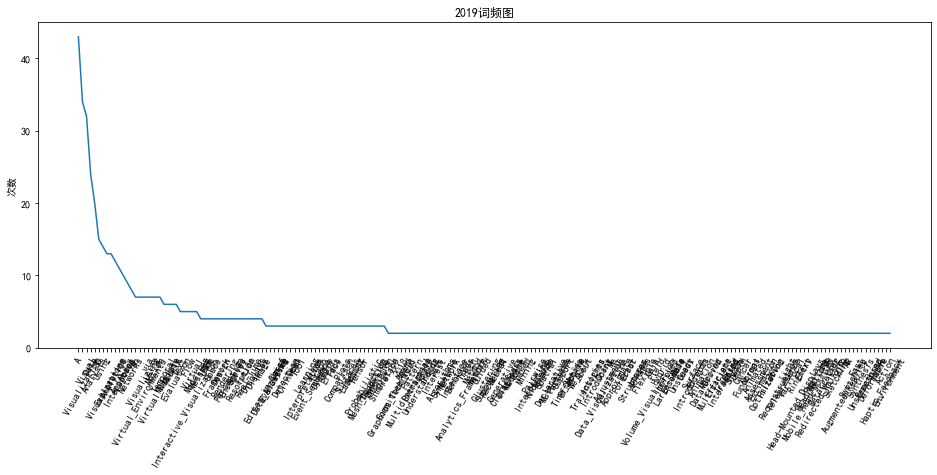

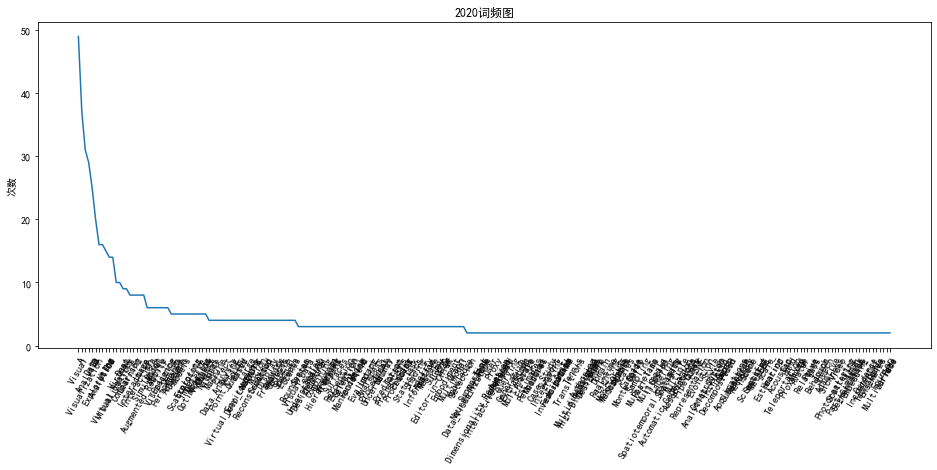

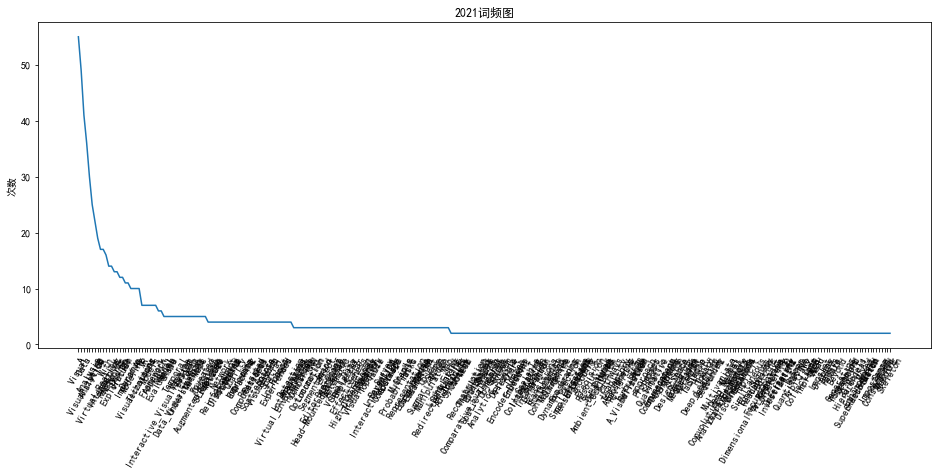

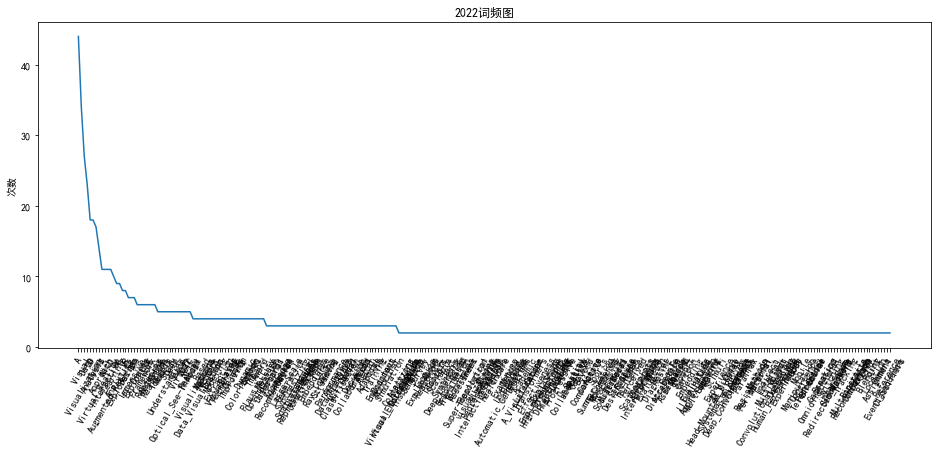

In [46]:
for year in range(1995, 2023):
    pltFig(year, 1)   # 分年查看词频大于1的所有词的词频情况

## 5 获取全年词频，绘图，观察

Visualization              625
A                          535
Visual                     447
Data                       356
Using                      304
Analysis                   294
Interactive                186
3D                         182
Exploration                171
Rendering                  134
Analytics                  132
The                        129
Virtual_Reality            102
Approach                    97
An                          97
Virtual                     94
Visualizing                 94
Visualizations              89
Design                      87
Augmented_Reality           83
Dynamic                     78
Editor's                    78
Surfaces                    77
Model                       72
Networks                    66
Framework                   65
Modeling                    64
Guest                       64
Image                       62
Evaluation                  60
Models                      59
Introduction_Special        58
Informat

Text(0.5, 1.0, '全28年词频图')

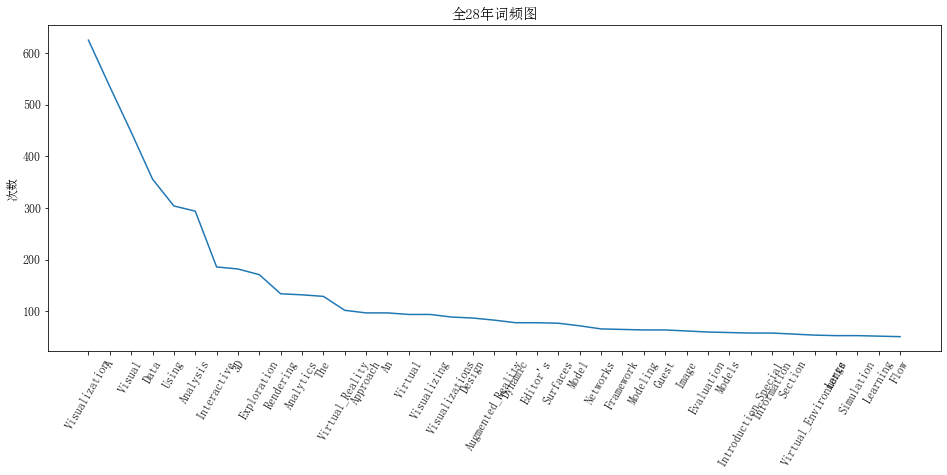

In [47]:
from matplotlib import rcParams

config = {
            "font.family": 'serif',
            "font.size": 12,# 相当于小四大小
            "mathtext.fontset": 'stix',#matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
            "font.serif": ['SimSun'],#宋体
            'axes.unicode_minus': False # 处理负号，即-号
         }
rcParams.update(config)

# 全年词频
DictByYear = load_variable1('wordFreqDict.txt')
allYearDict = dict()
for year in range(1995, 2023):
    curWords = DictByYear[year][2]
    
    for k, v in curWords.items():
        allYearDict[k] = allYearDict.get(k, 0) + v
        
# print(allYearDict.items())

items = list(allYearDict.items())  # 转换为list
length = len(items)

# print("items.len = " + str(len(items)))  # ●2 不一样的词的个数
items.sort(key=lambda x: x[1], reverse=True)  # 按照词频排序


wordcloudDic = dict()  # ●3 存放前k个词 & 词频

top_k = 1000

for i in range(top_k):
    word, count = items[i]
    wordcloudDic[word] = count
    print("{0:<20}{1:>10}".format(word, count))


# 只画出词频大于50的词，看看情况
plt_dic = dict()
for k, v in wordcloudDic.items():
    if v > 50:
        plt_dic[k] = v
# ------------------------------------------ 词频图
x1 = list(plt_dic.keys())
y1 = list(plt_dic.values())
plt.figure(figsize=(16, 6))
plt.plot(x1, y1)
plt.xticks(rotation=60)  # 设置x轴上的刻度旋转角度
plt.ylabel('次数')
plt.title('全28年词频图')

## 6
### 下面获取每年的文章数和文章标题 & 存储下来
形如：`{1995: [文章数、文章标题], 1996: [文章数、文章标题], }`

In [49]:
def saveTitleByYear(targetCol, year, targetField, titleDict):
    
    titleDict[year] = list()
    
    exec(targetCol + " = db_tvcg_28years['" + targetCol+ "']")
    loc = locals()
    
    Titles = {}  # key(词汇)，value(词频数)

    queryCondition = {"year": year}
    exec("recs = " + targetCol + ".find(queryCondition)")
    
    currentContent = list()
    for cT in loc['recs']:
        currentContent.append(cT.get(targetField))
        tempCnt_Titles = len(currentContent)  # 存放当年的总文章数

    titleDict[year].append(tempCnt_Titles)
    titleDict[year].append(currentContent)

In [50]:
targetCol = 'col_tvcg_28years'
titleDict = dict()

for year in range(1995, 2023):
    saveTitleByYear(targetCol, year, 'title', titleDict)
    

In [52]:
save_variable1(titleDict, 'resTitles_withType.txt')

'resTitles_withType.txt'

In [53]:
save_variable2(str(titleDict), 'resTitles_withoutType.txt')

'resTitles_withoutType.txt'

In [59]:
titlesDict = load_variable1('resTitles_withType.txt')

In [60]:
for year in range(1995, 2023):
    print(f"{year}的文章标题为：")
    print("-----------------------")
    for temp in titlesDict[year][1]:
        print(temp)
    print("============================================================")

1995的文章标题为：
-----------------------
Editorials.
Real Time Responsive Animation with Personality.
Visualizing Network Data.
Volume Rendering of DCT-Based Compressed 3D Scalar Data.
Visualization of Multidimensional Shape and Texture Features in Laser Range Data Using Complex-Valued Gabor Wavelets.
Optimal Sampling for Hemicubes.
Vision - An Architecture for Global Illumination Calculations.
Visualization Takes its Place in the Scientific Community.
Optical Models for Direct Volume Rendering.
Multiscale Volume Representation by a DoG Wavelet.
Grouping Volume Renderers for Enhanced Visualization in Computational Fluid Dynamics.
Using Line Integral Convolution for Flow Visualization: Curvilinear Grids, Variable-Speed Animation, and Unsteady Flows.
Competent, Compact, Comparative Visualization of a Vortical Flow Field.
A Predictor-Corrector Technique for Visualizing Unsteady Flow.
Quaternion Frame Approach to Streamline Visualization.
Obliq-3D: A High-Level, Fast-Turnaround 3D Animation Sys

A Perception Correlated Comparison Method for Dynamic Meshes.
Geometry Synthesis on Surfaces Using Field-Guided Shape Grammars.
Directing Crowd Simulations Using Navigation Fields.
The Effect on Lower Spine Muscle Activation of Walking on a Narrow Beam in Virtual Reality.
Erratum to "How Information Visualization Novices Construct Visualizations".
Editorial: EIC Farewell and New EIC Introduction.
A Message From the New Editor-in-Chief.
An Application of Multivariate Statistical Analysis for Query-Driven Visualization.
Tugging Graphs Faster: Efficiently Modifying Path-Preserving Hierarchies for Browsing Paths.
Hi-Trees and Their Layout.
A Comparison of Gradient Estimation Methods for Volume Rendering on Unstructured Meshes.
CGLX: A Scalable, High-Performance Visualization Framework for Networked Display Environments.
Correction of Clipped Pixels in Color Images.
GPU-Assisted Computation of Centroidal Voronoi Tessellation.
Interactive Mesh Cutting Using Constrained Random Walks.
Scan-Bas

Gaussian Cubes: Real-Time Modeling for Visual Exploration of Large Multidimensional Datasets.
cite2vec: Citation-Driven Document Exploration via Word Embeddings.
Molecular Surface Maps.
Synteny Explorer: An Interactive Visualization Application for Teaching Genome Evolution.
Visualizing Shape Deformations with Variation of Geometric Spectrum.
Physics-Based Visual Characterization of Molecular Interaction Forces.
PelVis: Atlas-based Surgical Planning for Oncological Pelvic Surgery.
Corresponding Supine and Prone Colon Visualization Using Eigenfunction Analysis and Fold Modeling.
Combined Visualization of Vessel Deformation and Hemodynamics in Cerebral Aneurysms.
Visualization as Seen through its Research Paper Keywords.
Comparing Cross-Sections and 3D Renderings for Surface Matching Tasks Using Physical Ground Truths.
Urban Pulse: Capturing the Rhythm of Cities.
Visualization and Extraction of Carvings for Heritage Conservation.
In Situ Distribution Guided Analysis and Visualization of 

Visualization Techniques in Augmented Reality: A Taxonomy, Methods and Patterns.
VIS30K: A Collection of Figures and Tables From IEEE Visualization Conference Publications.
Visual Model Fit Estimation in Scatterplots: Influence of Amount and Decentering of Noise.
Immersion and Coherence: Research Agenda and Early Results.
Visual Analytics for Hypothesis-Driven Exploration in Computational Pathology.
Learning Physical Parameters and Detail Enhancement for Gaseous Scene Design Based on Data Guidance.
UrbanMotion: Visual Analysis of Metropolitan-Scale Sparse Trajectories.
Video Folding: Increased Framerate for Semi-Repetitive Sequences.
Void Space Surfaces to Convey Depth in Vessel Visualizations.
Topology Constrained Shape Correspondence.
SpotSDC: Revealing the Silent Data Corruption Propagation in High-Performance Computing Systems.
Interactive Steering of Hierarchical Clustering.
PICO: Procedural Iterative Constrained Optimizer for Geometric Modeling.
Top-Down Shape Abstraction Based o

每年的文章数（1995~2022）：
32
35
30
28
26
29
30
30
49
66
72
171
178
166
163
162
245
271
277
247
126
242
248
294
290
305
384
284


Text(0.5, 1.0, '近28年的TVCG论文数')

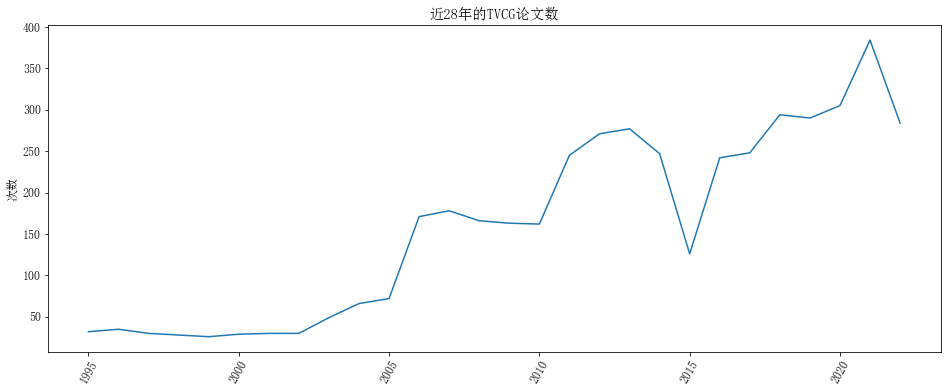

In [61]:
year_numbers = dict()
print("每年的文章数（1995~2022）：")
for year in range(1995, 2023):
    print(titlesDict[year][0])
    year_numbers[year] = titlesDict[year][0]
    
x1 = list(year_numbers.keys())
y1 = list(year_numbers.values())
plt.figure(figsize=(16, 6))
plt.plot(x1, y1)
plt.xticks(rotation=60)  # 设置x轴上的刻度旋转角度
plt.ylabel('次数')
plt.title('近28年的TVCG论文数')